In [55]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sys
from scipy.stats import poisson
from scipy.stats import multivariate_normal
from scipy.integrate import quad,simps, dblquad, cumtrapz
from chainconsumer import ChainConsumer
import pyccl as ccl
import time
%load_ext autoreload
%autoreload 2
sys.path.append('/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/modeling/')
import CL_COUNT_class_cluster_abundance as cl_count
import DATAOPS_Fisher_matrix as fisher
import CL_COUNT_MVP_cluster_abundance_prediction as mvp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
FM = fm.Fisher_matrix_prediction()
cosmo_true = FM.cosmo_true

In [272]:
mu_list = np.logspace(-1,4,100)
var_SSC_list = np.logspace(-3,3,100)
MVP = mvp.MVP(mu_list, var_SSC_list)

In [273]:
MVP._set_axis(5, mu_list, var_SSC_list)

In [274]:
N, P_MVP = MVP.p_mvp(mu_list, var_SSC_list)

/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/modeling/CL_COUNT_MVP_cluster_abundance_prediction.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  P_MVP_table = simps(_integrand_, self.array)


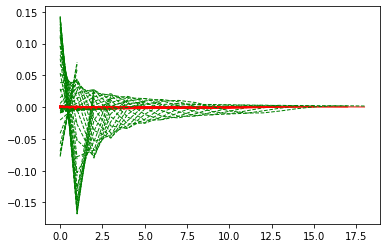

In [275]:
err_Poiss = []
err_Gauss = []
for n, p_mvp, i in zip(N, P_MVP, np.arange(len(N))):
    mu = mu_list[i]
    rv = poisson(mu)
    n_sigma = 3
    mask = (n > mu - n_sigma*np.sqrt((var_SSC_list[i] + mu)))*(n < mu + n_sigma*np.sqrt((var_SSC_list[i] + mu)))
    poisson_ = rv.pmf(n)
    pdf = multivariate_normal.pdf(n, mean=mu, 
                                  cov=var_SSC_list[i] + mu)
    if mu < 10:
        plt.plot(n[mask], p_mvp[mask]-poisson_[mask], '-r', linewidth = 1)
        #plt.plot(n[mask], pdf[mask]/np.sum(pdf), '-.r', linewidth = 2)
        plt.plot(n[mask], p_mvp[mask]-pdf[mask]/np.sum(pdf), '--g', linewidth = 1)
        
    err_gauss = 100*np.mean((abs(p_mvp[mask] - pdf[mask])/np.sum(pdf))/p_mvp[mask])
    err_poiss = 100*np.mean((abs(p_mvp[mask] - poisson_[mask])/p_mvp[mask]))
    err_Gauss.append(err_gauss)
    err_Poiss.append(err_poiss)
err_Gauss = np.array(err_Gauss)
err_Poiss = np.array(err_Poiss)

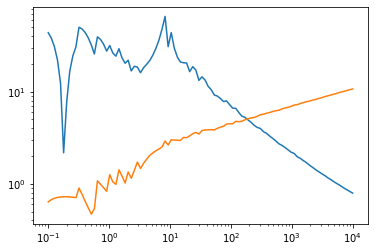

In [276]:
plt.plot(mu_list, err_Gauss)
plt.plot(mu_list, err_Poiss)
plt.xscale('log')
plt.yscale('log')